# Głębokie sieci neuronowe z rozgałęzieniami

In [ ]:
import os

# Ustawienie PyTorch jako zaplecza dla biblioteki Keras
os.environ["KERAS_BACKEND"] = "torch"

# PyTorch i keras
import torch
import keras
from keras import datasets, callbacks, layers, models, optimizers, losses

import numpy as np
import matplotlib.pyplot as plt

# Sprawdzenie dostępności GPU
#print(tf.config.list_physical_devices('GPU'))
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    if torch.xpu.is_available():
        for i in range(torch.xpu.device_count()):
            print(f"XPU {i}: {torch.xpu.get_device_name(i)}")
    else:
        print("Brak dostępnych GPU lub XPU.")
        print("Używam CPU.")

GPU 0: NVIDIA GeForce 940MX


## Przygotowanie zestawu danych CIFAR10
Przykłady w tym zbiorze mają format 32 na 32 punkty i są kolorowe, a więc posiadają trzy kanały.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Weryfikacja przykładów

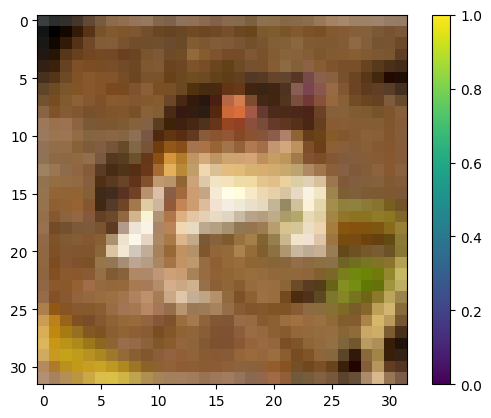

(32, 32, 3)


In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

input_shape = train_images[0].shape
if len(input_shape) < 3:
    input_shape += tuple([1])
print(input_shape)

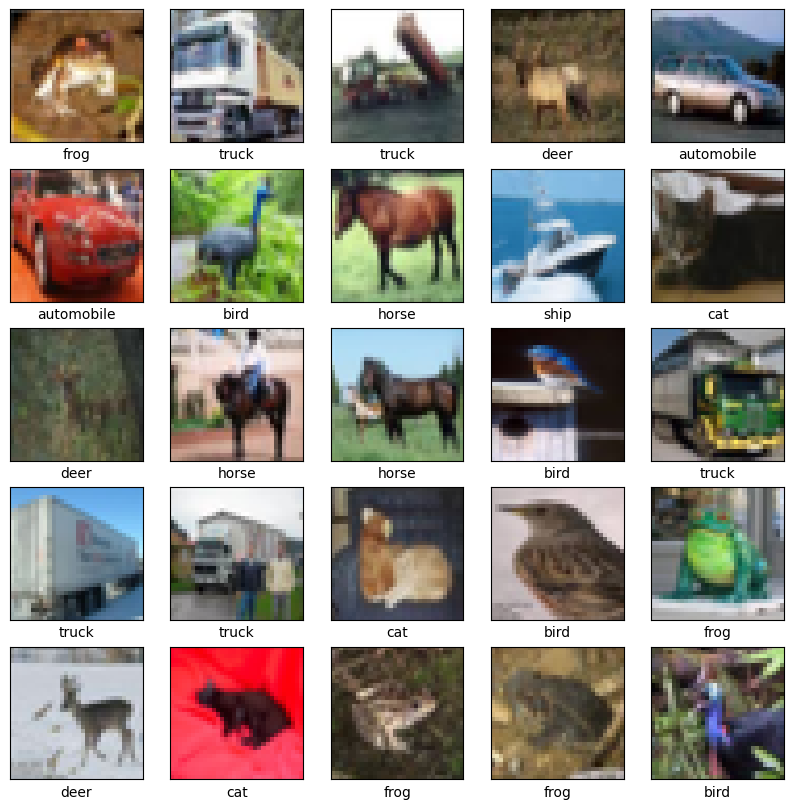

10

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()
len(class_names)

### Wstępne przetważanie

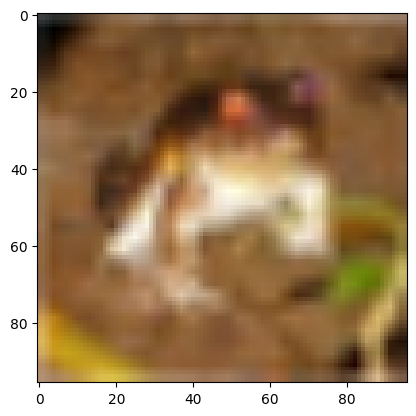

In [22]:
IMG_SIZE = 96
input_resize = layers.Resizing(IMG_SIZE, IMG_SIZE)

plt.imshow(input_resize(train_images[0]).cpu()) # .cpu() - aby przenieść tensor PyTorch na CPU

## Blok z obejściem

In [21]:
class Residual(keras.Model):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return keras.activations.relu(Y)

In [60]:
class ResidualBottleneck(keras.Model):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, strides=1):
        super().__init__()
        self.conv1 = layers.Conv2D(num_channels, padding='same',
                                            kernel_size=1, strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = layers.Conv2D(num_channels * 4, kernel_size=1,
                                            padding='same')
        self.conv4 = layers.Conv2D(num_channels * 4, kernel_size=1, strides=strides)

        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

    def call(self, X):
        Y = keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        Y = self.bn3(self.conv3(Y))

        X = self.conv4(X)
        Y += X
        return keras.activations.relu(Y)

### ResNet-18

In [48]:
def b1():
    return  models.Sequential([
            layers.Conv2D(64, kernel_size=7, strides=2,
                                   padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPool2D(pool_size=3, strides=2,
                                      padding='same')])

def resnet_module(num_residuals, num_channels, first_block=False):
    blk = models.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

def resnet(arch, classifier_input, num_classes):
    net = models.Sequential([
        keras.Input(shape=classifier_input),
        input_resize,
        b1()
    ])

    for i, b in enumerate(arch):
        net.add(resnet_module(*b, first_block=(i==0)))

    net.add(models.Sequential([
        layers.GlobalAvgPool2D(),
        layers.Dense(units=num_classes)]
    ))
    return net

def resnet_18(classifier_input, num_classes):
    return resnet(((2, 64), (2, 128), (2, 256), (2, 512)),
                       classifier_input, num_classes)

def resnet_34(classifier_input, num_classes):
    return resnet(((3, 64), (4, 128), (6, 256), (3, 512)),
                    classifier_input, num_classes)




In [40]:
def b1_smol():
    return  models.Sequential([
            layers.Conv2D(16, kernel_size=3, strides=2,
                                  padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),])

def resnet_main_smol(arch, classifier_input, num_classes):
    net = models.Sequential([
        keras.Input(shape=classifier_input),
        b1_smol()
    ])

    for i, b in enumerate(arch):
        net.add(resnet_module(*b, first_block=(i==0)))

    net.add(models.Sequential([
        layers.GlobalAvgPool2D(),
        layers.Dense(units=num_classes)]
    ))
    return net


def resnet_smol(classifier_input, num_classes):
    return resnet_main_smol(((6, 16), (6, 32), (6, 64)),
                    classifier_input, num_classes)


In [62]:
def resnet_module_bneck(num_residuals, num_channels, first_block=False):
    blk = models.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(ResidualBottleneck(num_channels, strides=2))
        else:
            blk.add(ResidualBottleneck(num_channels))
    return blk

def resnet_main_smol_bneck(arch, classifier_input, num_classes):
    net = models.Sequential([
        keras.Input(shape=classifier_input),
        b1_smol()
    ])

    for i, b in enumerate(arch):
        net.add(resnet_module_bneck(*b, first_block=(i==0)))

    net.add(models.Sequential([
        layers.GlobalAvgPool2D(),
        layers.Dense(units=num_classes)]
    ))
    return net

def resnet_smol_bneck(classifier_input, num_classes):
    return resnet_main_smol_bneck(((6, 16), (6, 32), (6, 64)),
                    classifier_input, num_classes)


### Wybór modelu

In [63]:
model = resnet_smol_bneck(input_shape, len(class_names))
model.summary()

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_79 (Sequential)      │ (None, 16, 16, 16)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_81 (Sequential)      │ (None, 16, 16, 64)     │        50,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_82 (Sequential)      │ (None, 8, 8, 128)      │       199,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_83 (Sequential)      │ (None, 4, 4, 256)      │       783,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_84 (Sequential)      │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,338 (3.95 MB)

 Trainable params: 1,027,242 (3.92 MB)

 Non-trainable params: 8,096 (31.62 KB)

### Skład i trening modelu

In [66]:

model.compile(optimizer=optimizers.Adam(learning_rate = 0.01),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=15,
                    validation_data=(test_images, test_labels),
                    batch_size=128
                    )

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 62s 158ms/step - accuracy: 0.2114 - loss: 2.2819 - val_accuracy: 0.2902 - val_loss: 1.9549
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 161ms/step - accuracy: 0.3815 - loss: 1.6511 - val_accuracy: 0.3460 - val_loss: 1.7529
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - accuracy: 0.4230 - loss: 1.5491 - val_accuracy: 0.4070 - val_loss: 1.6147
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - accuracy: 0.4531 - loss: 1.4716 - val_accuracy: 0.2249 - val_loss: 2.7443
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 161ms/step - accuracy: 0.4775 - loss: 1.4256 - val_accuracy: 0.3058 - val_loss: 2.4086
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - accuracy: 0.4643 - loss: 1.4669 - val_accuracy: 0.3207 - val_loss: 1.8649
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - accuracy: 0.4734 - loss: 1.4270 - val_accuracy: 0.3597 - val_loss: 1.8790
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 159ms/step - accuracy: 0.5271 - loss: 1

### Wyniki

313/313 - 18s - 57ms/step - accuracy: 0.5154 - loss: 1.5002


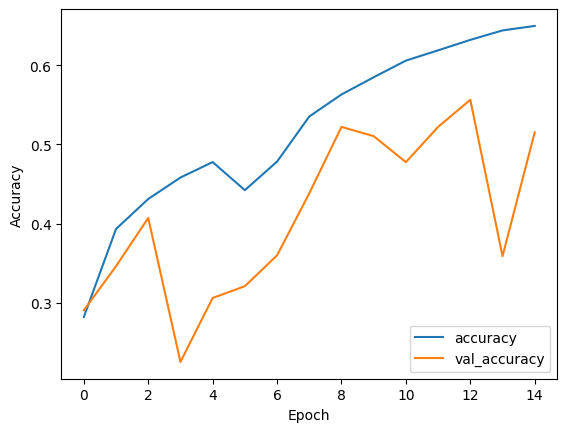

In [67]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [19]:
print(test_acc)

0.6280999779701233


# Zadania
1.  Przetestuj inny wariant sieci ResNet, spośród opisanych w tabeli 1 z poniższego artykułu: https://doi.org/10.1109/CVPR.2016.90. Dostosuj go do przyjmowania danych w formacie 32 na 32 (2 pkt)
2. Dodaj przewężenia w architekturze sieci (ang. bottleneck). (2 pkt)
3. W kolejnych udoskonaleniach autorzy zmieniają schemat "splot, normalizacja wsadu i aktywacja" na "normalizacja wsadu, aktywacja i splot". Dodaj to usprawnienie. Jako wzór możesz wykorzystać rysunek 1 z artykułu: https://doi.org/10.1007/978-3-319-46493-0_38 (1 pkt)